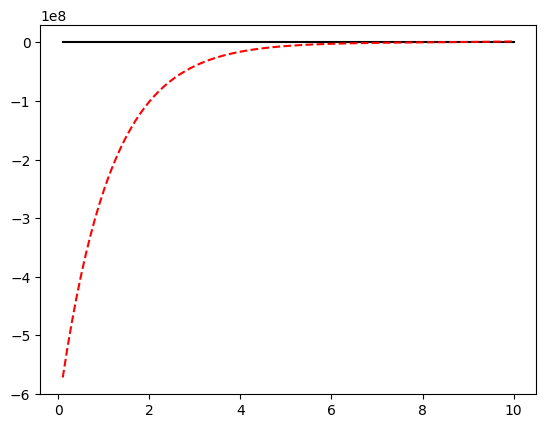

In [27]:
#forward calculation for pumping (2D)
from scipy.optimize import least_squares
import numpy as np
import scipy
from scipy import special
from numpy.polynomial.hermite import hermfit,hermval
from numpy.polynomial.polynomial import polyfit 
import matplotlib.pyplot as plt
import math
from scipy.signal import savgol_filter
from scipy.optimize import differential_evolution
from scipy.optimize import minimize

def fun_der(lk,rs,ns,r,q,ta,s,t,r0):   
    t_len=len(t); r_len=len(r); ini_len=len(r0)
    d_s=len(rs) 
    rcoe=np.zeros((ini_len+(d_s-1)*2+t_len*(r_len+2*(d_s-1)),sum(ns)*2))
    ycoe=np.zeros(ini_len+(d_s-1)*2+t_len*(r_len+2*(d_s-1)))
# Initial Condition
    for ik in range(ini_len):
        rk=r0[ik]
        for nn in range(d_s-1):
            if (rk<=rs[0]):
                nkk=0
                rk1=rk+0.2
            else:
                if (rs[nn]<rk<=rs[nn+1]):
                    nkk=nn+1
                    rk1=rk-rs[nn]+0.2
            for jk in range(1,ns[nkk]+1):
                vk=jk*1.0*np.pi/lk[nkk]
                nk=(jk-1)*2+sum(ns[0:nkk])*2
                rcoe[ik,nk+0]=scipy.special.jv(0,rk1*vk)
                rcoe[ik,nk+1]=scipy.special.yv(0,rk1*vk)
        ycoe[ik]=52.0
    nk_f=ini_len
# for interface
    for nn in range(d_s-1):
        nkk=nn
        rk=rs[nn]+0.2
        for jk in range(1,ns[nkk]+1):
            vk=jk*1.0*np.pi/lk[nkk]
            nk=(jk-1)*2+sum(ns[0:nkk])*2
            rcoe[nk_f,nk+0]=scipy.special.jv(0,rk*vk)
            rcoe[nk_f,nk+1]=scipy.special.yv(0,rk*vk)
        nkk=nn+1
        rk=0.0+0.2
        for jk in range(1,ns[nkk]+1):
            vk=jk*1.0*np.pi/lk[nkk]
            nk=(jk-1)*2+sum(ns[0:nkk])*2
            rcoe[nk_f,nk+0]=-scipy.special.jv(0,rk*vk)
            rcoe[nk_f,nk+1]=-scipy.special.yv(0,rk*vk)
        ycoe[nk_f]=0.0
        nk_f=nk_f+1
        
        nkk=nn
        rk=rs[nn]+0.2
        for jk in range(1,ns[nkk]+1):
            vk=jk*1.0*np.pi/lk[nkk]
            nk=(jk-1)*2+sum(ns[0:nkk])*2
            rcoe[nk_f,nk+0]=scipy.special.jvp(0,rk*vk)*vk
            rcoe[nk_f,nk+1]=scipy.special.yvp(0,rk*vk)*vk
        nkk=nn+1
        rk=0.0+0.2
        for jk in range(1,ns[nkk]+1):
            vk=jk*1.0*np.pi/lk[nkk]
            nk=(jk-1)*2+sum(ns[0:nkk])*2
            rcoe[nk_f,nk+0]=-scipy.special.jvp(0,rk*vk)*vk
            rcoe[nk_f,nk+1]=-scipy.special.yvp(0,rk*vk)*vk
        ycoe[nk_f]=0.0
        nk_f=nk_f+1       
            
        
# Boundary Condition
    nk_f=ini_len
    for ik in range(t_len):
        tk=t[ik]
        rk=r[0]+0.2
        for jk in range(1,ns[0]+1):
            vk=jk*1.0*np.pi/lk[0]
            nk=(jk-1)*2
            t_term=np.exp(-vk*vk*ta/s*tk)
            rcoe[nk_f,nk+0]=t_term*scipy.special.jvp(0,rk*vk)*vk
            rcoe[nk_f,nk+1]=t_term*scipy.special.yvp(0,rk*vk)*vk
        ycoe[nk_f]=+q/2.0/np.pi/rk/1.0
        nk_f=nk_f+1
        
        rk=r[1]-rs[d_s-2]+0.2
        for jk in range(1,ns[d_s-1]+1):
            vk=jk*1.0*np.pi/lk[d_s-1]
            nk=(jk-1)*2+sum(ns[0:(d_s-1)])*2
            t_term=np.exp(-vk*vk*ta/s*tk)
            rcoe[nk_f,nk+0]=t_term*scipy.special.jv(0,rk*vk)
            rcoe[nk_f,nk+1]=t_term*scipy.special.yv(0,rk*vk)
        ycoe[nk_f]=52.0
        nk_f=nk_f+1                     
            
# for interface
        for nn in range(d_s-1):
            rk=rs[nn]+0.2
            nkk=nn
            for jk in range(1,ns[nkk]+1):
                vk=jk*1.0*np.pi/lk[nkk]
                nk=(jk-1)*2+sum(ns[0:nkk])*2
                rcoe[nk_f,nk+0]=scipy.special.jv(0,rk*vk)
                rcoe[nk_f,nk+1]=scipy.special.yv(0,rk*vk)
            nkk=nn+1
            rk=0.0+0.2
            for jk in range(1,ns[nkk]+1):
                vk=jk*1.0*np.pi/lk[nkk]
                nk=(jk-1)*2+sum(ns[0:nkk])*2
                rcoe[nk_f,nk+0]=-scipy.special.jv(0,rk*vk)
                rcoe[nk_f,nk+1]=-scipy.special.yv(0,rk*vk)
            ycoe[nk_f]=0.0
            nk_f=nk_f+1
            
            rk=rs[nn]+0.2
            nkk=nn
            for jk in range(1,ns[nkk]+1):
                vk=jk*1.0*np.pi/lk[nkk]
                nk=(jk-1)*2+sum(ns[0:nkk])*2
                rcoe[nk_f,nk+0]=scipy.special.jvp(0,rk*vk)*vk
                rcoe[nk_f,nk+1]=scipy.special.yvp(0,rk*vk)*vk
            nkk=nn+1
            rk=0.0+0.2
            for jk in range(1,ns[nkk]+1):
                vk=jk*1.0*np.pi/lk[nkk]
                nk=(jk-1)*2+sum(ns[0:nkk])*2
                rcoe[nk_f,nk+0]=-scipy.special.jvp(0,rk*vk)*vk
                rcoe[nk_f,nk+1]=-scipy.special.yvp(0,rk*vk)*vk
            ycoe[nk_f]=0.0
            nk_f=nk_f+1
            
        
    ck=np.linalg.lstsq(rcoe,ycoe,rcond=None)[0]
    
# Calculate the residual
    resk1=np.zeros(ini_len+(d_s-1)*2+t_len*(r_len+2*(d_s-1)))
    return ck,rcoe,ycoe
r0=np.zeros(1000)
r0[0]=0.15
for ik in range(1,1000):
    r0[ik]=ik*1.0
r=np.zeros(2)
r[0]=0.1; r[1]=1000.0
t=np.zeros(100)
for ik in range(100):
    t[ik]=(ik+1)*0.1
#lk=np.zeros(4); rs=np.zeros(4); ns=np.zeros(4,dtype=int)
#lk[0]=5000.0; lk[1]=5000.0; lk[2]=5000.0; lk[3]=5000.0
#rs[0]=100.0; rs[1]=300.0; rs[2]=700.0; rs[3]=1100.0
#ns[0]=100; ns[1]=20; ns[2]=20; ns[3]=20

lk=np.zeros(2); rs=np.zeros(2); ns=np.zeros(2,dtype=int)
lk[0]=1000.0; lk[1]=10000.0;
rs[0]=100.0; rs[1]=1100.0;
ns[0]=60; ns[1]=60; 
[ck,rcoe,ycoe]=fun_der(lk,rs,ns,r,1.0,1.0,0.01,t,r0)

t=np.zeros(100)
for ik in range(100):
    t[ik]=(ik+1)*0.1
s=np.zeros(100)
for ik in range(100):
    u=5.0*5.0*0.01/4.0/1.0/t[ik]
    w=-0.5772-np.log(u)
    for jk in range(1,100):
        w=w-((-1.0)**(jk))*(u**jk)/(jk*1.0)/np.math.factorial(jk)
    s[ik]=1.0/4.0/np.pi/1.0*w
plt.plot(t,s,'k-')
s1=np.zeros(100)
ta=1.0; ss=0.01
r0=np.zeros(1000)
r0[0]=0.1
for ik in range(1,1000):
    r0[ik]=ik*1.0
for ik in range(100):
    rkk=5.0+0.2; tk=t[ik]
    for jk in range(1,60):
        vk=jk*1.0*np.pi/lk[0]
        nk=(jk-1)*2
        t_term=np.exp(-vk*vk*ta/ss*tk)
        s1[ik]=s1[ik]+ck[nk+0]*t_term*scipy.special.jv(0,rkk*vk)
        s1[ik]=s1[ik]+ck[nk+1]*t_term*scipy.special.yv(0,rkk*vk)
    s1[ik]=s1[ik]
            
plt.plot(t,52.0-s1,'r--')

In [8]:
print(rcoe)
print(ycoe)

[[ 9.99999999e-01 -6.41627550e+00  9.99999998e-01 ... -2.60329787e+00
   9.99911176e-01 -2.60170304e+00]
 [ 9.99999975e-01 -5.20853126e+00  9.99999901e-01 ... -1.38786546e+00
   9.96056053e-01 -1.38623822e+00]
 [ 9.99999901e-01 -4.76725967e+00  9.99999605e-01 ... -9.29685013e-01
   9.84270865e-01 -9.27992240e-01]
 ...
 [ 9.75382466e-01 -7.75393429e-01  9.03359507e-01 ... -1.11522082e-08
   8.16325690e-09 -8.17951283e-09]
 [-4.93431518e-09  6.36556947e+00 -1.97314176e-08 ...  9.55420606e-07
  -1.09465582e-10  8.82973599e-07]
 [ 9.75381503e-01 -7.75392664e-01  9.03355941e-01 ... -9.53064534e-09
   6.97079689e-09 -6.98467820e-09]]
[52.         52.         52.         ... 52.          1.59154943
 52.        ]


In [129]:
#forward calculation for pumping (2D)
from scipy.optimize import least_squares
import numpy as np
import scipy
from scipy import special
from numpy.polynomial.hermite import hermfit,hermval
from numpy.polynomial.polynomial import polyfit 
import matplotlib.pyplot as plt
import math
from scipy.signal import savgol_filter
from scipy.optimize import differential_evolution
from scipy.optimize import minimize

def fun_der1(lk1,lk2,r,q,ta,s,t,r0):
    t_len=len(t); r_len=len(r); ini_len=len(r0)
    rcoe=np.zeros((ini_len+2+t_len*(r_len+2),100*4))
    ycoe=np.zeros(ini_len+2+t_len*(r_len+2))
# Initial Condition
    for ik in range(ini_len):
        rk=r0[ik]
        for jk in range(1,101):
            if (rk<100.0):
                vk=jk*1.0*np.pi/lk1
                nk=(jk-1)*2
                rk1=rk
            else:
                vk=jk*1.0*np.pi/lk2
                nk=(jk-1)*2+200
                rk1=rk-99.8
            rcoe[ik,nk+0]=scipy.special.jv(0,rk1*vk)
            rcoe[ik,nk+1]=scipy.special.yv(0,rk1*vk)
        ycoe[ik]=52.0
# For the interface in the initial condition
    nk_f=ini_len
    rk=100.0
    for jk in range(1,101):
        vk=jk*1.0*np.pi/lk1
        nk=(jk-1)*2
        rcoe[nk_f,nk+0]=scipy.special.jv(0,rk*vk)
        rcoe[nk_f,nk+1]=scipy.special.yv(0,rk*vk)
        
        vk=jk*1.0*np.pi/lk2
        nk=(jk-1)*2+200
        rk1=rk-99.8
        rcoe[nk_f,nk+0]=-scipy.special.jv(0,rk1*vk)
        rcoe[nk_f,nk+1]=-scipy.special.yv(0,rk1*vk)
    ycoe[nk_f]=0.0
    nk_f=nk_f+1    
    
    for jk in range(1,101):
        vk=jk*1.0*np.pi/lk1
        nk=(jk-1)*2
        rcoe[nk_f,nk+0]=vk*scipy.special.jvp(0,rk*vk)
        rcoe[nk_f,nk+1]=vk*scipy.special.yvp(0,rk*vk)
        
        vk=jk*1.0*np.pi/lk2
        nk=(jk-1)*2+200
        rk1=rk-99.8
        rcoe[nk_f,nk+0]=-vk*scipy.special.jvp(0,rk1*vk)
        rcoe[nk_f,nk+1]=-vk*scipy.special.yvp(0,rk1*vk)
    ycoe[nk_f]=1.0e-2
    nk_f=nk_f+1
    
    for ik in range(t_len):
        tk=t[ik]
# Boundary Condition
        rk=r[0]
        for jk in range(1,101):
            vk=jk*1.0*np.pi/lk1
            nk=(jk-1)*2
            t_term=np.exp(-vk*vk*ta/s*tk)
            rcoe[nk_f,nk+0]=t_term*scipy.special.jvp(0,rk*vk)*vk
            rcoe[nk_f,nk+1]=t_term*scipy.special.yvp(0,rk*vk)*vk
        ycoe[nk_f]=+q/2.0/np.pi/rk/1.0
        nk_f=nk_f+1
        
        rk=r[1]-99.8
        for jk in range(1,101):
            vk=jk*1.0*np.pi/lk2
            nk=(jk-1)*2+200
            t_term=np.exp(-vk*vk*ta/s*tk)
            rcoe[nk_f,nk+0]=t_term*scipy.special.jv(0,rk*vk)
            rcoe[nk_f,nk+1]=t_term*scipy.special.yv(0,rk*vk)
        ycoe[nk_f]=52.0
        nk_f=nk_f+1
    
# For interface
        rk=100.0
        for jk in range(1,101):
            vk=jk*1.0*np.pi/lk1
            nk=(jk-1)*2
            t_term=np.exp(-vk*vk*ta/s*tk)
            rcoe[nk_f,nk+0]=t_term*scipy.special.jv(0,rk*vk)
            rcoe[nk_f,nk+1]=t_term*scipy.special.yv(0,rk*vk)
            
            vk=jk*1.0*np.pi/lk2
            nk=(jk-1)*2+200
            rk1=rk-99.8
            t_term=np.exp(-vk*vk*ta/s*tk)
            rcoe[nk_f,nk+0]=-t_term*scipy.special.jv(0,rk1*vk)
            rcoe[nk_f,nk+1]=-t_term*scipy.special.yv(0,rk1*vk)
        ycoe[nk_f]=0.0
        nk_f=nk_f+1
        
        for jk in range(1,101):
            vk=jk*1.0*np.pi/lk1
            nk=(jk-1)*2
            t_term=np.exp(-vk*vk*ta/s*tk)
            rcoe[nk_f,nk+0]=t_term*vk*scipy.special.jvp(0,rk*vk)
            rcoe[nk_f,nk+1]=t_term*vk*scipy.special.yvp(0,rk*vk)
            
            vk=jk*1.0*np.pi/lk2
            nk=(jk-1)*2+200
            rk1=rk-99.8
            t_term=np.exp(-vk*vk*ta/s*tk)
            rcoe[nk_f,nk+0]=-t_term*vk*scipy.special.jvp(0,rk1*vk)
            rcoe[nk_f,nk+1]=-t_term*vk*scipy.special.yvp(0,rk1*vk)
        ycoe[nk_f]=0.0
        nk_f=nk_f+1
            
    ck=np.linalg.lstsq(rcoe,ycoe,rcond=None)[0]
    
# Calculate the residual
    resk1=np.zeros(ini_len+2+t_len*(r_len+2))
# Initial Condition
    for ik in range(ini_len):
        rk=r0[ik]
        for jk in range(1,101):
            if (rk<100.0):
                vk=jk*1.0*np.pi/lk1
                nk=(jk-1)*2
                rk1=rk
            else:
                vk=jk*1.0*np.pi/lk2
                nk=(jk-1)*2+200
                rk1=rk-99.8
            resk1[ik]=resk1[ik]+ck[nk+0]*scipy.special.jv(0,rk1*vk)
            resk1[ik]=resk1[ik]+ck[nk+1]*scipy.special.yv(0,rk1*vk)
        resk1[ik]=resk1[ik]-52.0
# For the interface in the initial condition
    nk_f=ini_len
    rk=100.0
    for jk in range(1,101):
        vk=jk*1.0*np.pi/lk1
        nk=(jk-1)*2
        resk1[nk_f]=resk1[nk_f]+ck[nk+0]*scipy.special.jv(0,rk*vk)
        resk1[nk_f]=resk1[nk_f]+ck[nk+1]*scipy.special.yv(0,rk*vk)
        
        vk=jk*1.0*np.pi/lk2
        nk=(jk-1)*2+200
        rk1=rk-99.8
        resk1[nk_f]=resk1[nk_f]-ck[nk+0]*scipy.special.jv(0,rk1*vk)
        resk1[nk_f]=resk1[nk_f]-ck[nk+1]*scipy.special.yv(0,rk1*vk)
    nk_f=nk_f+1
    
    for jk in range(1,101):
        vk=jk*1.0*np.pi/lk1
        nk=(jk-1)*2
        resk1[nk_f]=resk1[nk_f]+ck[nk+0]*vk*scipy.special.jvp(0,rk*vk)
        resk1[nk_f]=resk1[nk_f]+ck[nk+1]*vk*scipy.special.yvp(0,rk*vk)
        
        vk=jk*1.0*np.pi/lk2
        nk=(jk-1)*2+200
        rk1=rk-99.8
        resk1[nk_f]=resk1[nk_f]-ck[nk+0]*vk*scipy.special.jvp(0,rk1*vk)
        resk1[nk_f]=resk1[nk_f]-ck[nk+1]*vk*scipy.special.yvp(0,rk1*vk)
    nk_f=nk_f+1
    
    for ik in range(t_len):
        tk=t[ik]
# Boundary Condition
        rk=r[0]
        for jk in range(1,101):
            vk=jk*1.0*np.pi/lk1
            nk=(jk-1)*2
            t_term=np.exp(-vk*vk*ta/s*tk)
            resk1[nk_f]=resk1[nk_f]+ck[nk+0]*t_term*scipy.special.jvp(0,rk*vk)*vk
            resk1[nk_f]=resk1[nk_f]+ck[nk+1]*t_term*scipy.special.yvp(0,rk*vk)*vk
        resk1[nk_f]=resk1[nk_f]-q/2.0/np.pi/rk/1.0
        nk_f=nk_f+1
        
        rk=r[1]-99.8
        for jk in range(1,101):
            vk=jk*1.0*np.pi/lk2
            nk=(jk-1)*2+200
            t_term=np.exp(-vk*vk*ta/s*tk)
            resk1[nk_f]=resk1[nk_f]+ck[nk+0]*t_term*scipy.special.jv(0,rk*vk)
            resk1[nk_f]=resk1[nk_f]+ck[nk+1]*t_term*scipy.special.yv(0,rk*vk)
        resk1[nk_f]=resk1[nk_f]-52.0
        nk_f=nk_f+1
            
# For interface
        rk=100.0
        for jk in range(1,101):
            vk=jk*1.0*np.pi/lk1
            nk=(jk-1)*2
            t_term=np.exp(-vk*vk*ta/s*tk)
            resk1[nk_f]=resk1[nk_f]+ck[nk+0]*t_term*scipy.special.jv(0,rk*vk)
            resk1[nk_f]=resk1[nk_f]+ck[nk+1]*t_term*scipy.special.yv(0,rk*vk)
            
            vk=jk*1.0*np.pi/lk2
            nk=(jk-1)*2+200
            rk1=rk-99.8
            t_term=np.exp(-vk*vk*ta/s*tk)
            resk1[nk_f]=resk1[nk_f]-ck[nk+0]*t_term*scipy.special.jv(0,rk1*vk)
            resk1[nk_f]=resk1[nk_f]-ck[nk+1]*t_term*scipy.special.yv(0,rk1*vk)
        nk_f=nk_f+1
        
        for jk in range(1,101):
            vk=jk*1.0*np.pi/lk1
            nk=(jk-1)*2
            t_term=np.exp(-vk*vk*ta/s*tk)
            resk1[nk_f]=resk1[nk_f]+ck[nk+0]*t_term*vk*scipy.special.jvp(0,rk*vk)
            resk1[nk_f]=resk1[nk_f]+ck[nk+1]*t_term*vk*scipy.special.yvp(0,rk*vk)
            
            vk=jk*1.0*np.pi/lk2
            nk=(jk-1)*2+200
            rk1=rk-99.8
            t_term=np.exp(-vk*vk*ta/s*tk)
            resk1[nk_f]=resk1[nk_f]-ck[nk+0]*t_term*vk*scipy.special.jvp(0,rk1*vk)
            resk1[nk_f]=resk1[nk_f]-ck[nk+1]*t_term*vk*scipy.special.yvp(0,rk1*vk)
        nk_f=nk_f+1
            
    print (sum(resk1*resk1))
    return ck,rcoe,ycoe
r0=np.zeros(1000)
r0[0]=0.15
for ik in range(1,1000):
    r0[ik]=ik*1.0
r=np.zeros(2)
r[0]=0.1; r[1]=1000.0
t=np.zeros(100)
for ik in range(100):
    t[ik]=(ik+1)*0.1
lk1=1000.0; lk2=10000.0
[ck,rcoe,ycoe]=fun_der1(lk1,lk2,r,1.0,1.0,0.001,t,r0)

9.036638430498906e-05


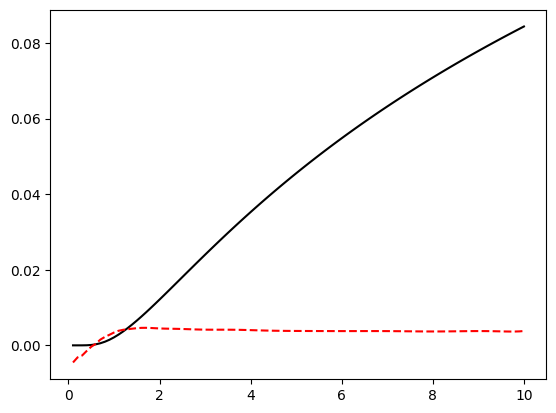

In [130]:
t=np.zeros(100)
for ik in range(100):
    t[ik]=(ik+1)*0.1
s=np.zeros(100)
for ik in range(100):
    u=99.0*99.0*0.001/4.0/1.0/t[ik]
    w=-0.5772-np.log(u)
    for jk in range(1,100):
        w=w-((-1.0)**(jk))*(u**jk)/(jk*1.0)/np.math.factorial(jk)
    s[ik]=1.0/4.0/np.pi/1.0*w
plt.plot(t,s,'k-')
s1=np.zeros(100)
ta=1.0; ss=0.001
r0=np.zeros(1000)
r0[0]=0.1
for ik in range(1,1000):
    r0[ik]=ik*1.0
for ik in range(100):
    rkk=99.0; tk=t[ik]
    for jk in range(1,101):
        vk=jk*1.0*np.pi/lk1
        nk=(jk-1)*2
        t_term=np.exp(-vk*vk*ta/ss*tk)
        s1[ik]=s1[ik]+ck[nk+0]*t_term*scipy.special.jv(0,rkk*vk)
        s1[ik]=s1[ik]+ck[nk+1]*t_term*scipy.special.yv(0,rkk*vk)
    s1[ik]=s1[ik]
            
plt.plot(t,52.0-s1,'r--')

In [123]:
#forward calculation for pumping (2D)
from scipy.optimize import least_squares
import numpy as np
import scipy
from scipy import special
from numpy.polynomial.hermite import hermfit,hermval
from numpy.polynomial.polynomial import polyfit 
import matplotlib.pyplot as plt
import math
from scipy.signal import savgol_filter
from scipy.optimize import differential_evolution
from scipy.optimize import minimize

def fun_der(lk,r,q,ta,s,t,r0):
    t_len=len(t); r_len=len(r); ini_len=len(r0)
    rcoe=np.zeros((ini_len+t_len*r_len,400*2))
    ycoe=np.zeros(ini_len+t_len*r_len)
# Initial Condition
    for ik in range(ini_len):
        rk=r0[ik]
        for jk in range(1,401):
            vk=jk*1.0*np.pi/lk
            nk=(jk-1)*2
            rcoe[ik,nk+0]=scipy.special.jv(0,rk*vk)
            rcoe[ik,nk+1]=scipy.special.yv(0,rk*vk)
        ycoe[ik]=52.0
# Boundary Condition
    nk_f=ini_len
    for ik in range(t_len):
        tk=t[ik]
        rk=r[0]
        for jk in range(1,401):
            vk=jk*1.0*np.pi/lk
            nk=(jk-1)*2
            t_term=np.exp(-vk*vk*ta/s*tk)
            rcoe[nk_f,nk+0]=t_term*scipy.special.jvp(0,rk*vk)*vk
            rcoe[nk_f,nk+1]=t_term*scipy.special.yvp(0,rk*vk)*vk
        ycoe[nk_f]=+q/2.0/np.pi/rk/1.0
        nk_f=nk_f+1
        
        rk=r[1]
        for jk in range(1,401):
            vk=jk*1.0*np.pi/lk
            nk=(jk-1)*2
            t_term=np.exp(-vk*vk*ta/s*tk)
            rcoe[nk_f,nk+0]=t_term*scipy.special.jv(0,rk*vk)
            rcoe[nk_f,nk+1]=t_term*scipy.special.yv(0,rk*vk)
        ycoe[nk_f]=52.0
        nk_f=nk_f+1
        
    ck=np.linalg.lstsq(rcoe,ycoe,rcond=None)[0]
    
# Calculate the residual
    resk1=np.zeros(ini_len+t_len*r_len)
# Initial Condition
    for ik in range(ini_len):
        rk=r0[ik]
        for jk in range(1,401):
            vk=jk*1.0*np.pi/lk
            nk=(jk-1)*2
            resk1[ik]=resk1[ik]+ck[nk+0]*scipy.special.jv(0,rk*vk)
            resk1[ik]=resk1[ik]+ck[nk+1]*scipy.special.yv(0,rk*vk)
        resk1[ik]=resk1[ik]-52.0
# Boundary Condition
    nk_f=ini_len
    for ik in range(t_len):
        tk=t[ik]
        rk=r[0]
        for jk in range(1,401):
            vk=jk*1.0*np.pi/lk
            nk=(jk-1)*2
            t_term=np.exp(-vk*vk*ta/s*tk)
            resk1[nk_f]=resk1[nk_f]+ck[nk+0]*t_term*scipy.special.jvp(0,rk*vk)*vk
            resk1[nk_f]=resk1[nk_f]+ck[nk+1]*t_term*scipy.special.yvp(0,rk*vk)*vk
        resk1[nk_f]=resk1[nk_f]-q/2.0/np.pi/rk/1.0
        nk_f=nk_f+1
        
        rk=r[1]
        for jk in range(1,401):
            vk=jk*1.0*np.pi/lk
            nk=(jk-1)*2
            t_term=np.exp(-vk*vk*ta/s*tk)
            resk1[nk_f]=resk1[nk_f]+ck[nk+0]*t_term*scipy.special.jv(0,rk*vk)
            resk1[nk_f]=resk1[nk_f]+ck[nk+1]*t_term*scipy.special.yv(0,rk*vk)
        resk1[nk_f]=resk1[nk_f]-52.0
        nk_f=nk_f+1
    print (sum(resk1*resk1))
    return ck,rcoe,ycoe
r0=np.zeros(1000)
r0[0]=0.15
for ik in range(1,1000):
    r0[ik]=ik*1.0
r=np.zeros(2)
r[0]=0.1; r[1]=1000.0
t=np.zeros(100)
for ik in range(100):
    t[ik]=(ik+1)*0.2
lk=10000.0
[ck,rcoe,ycoe]=fun_der(lk,r,1.0,1.0,0.001,t,r0)


1.2599032821111553e-06


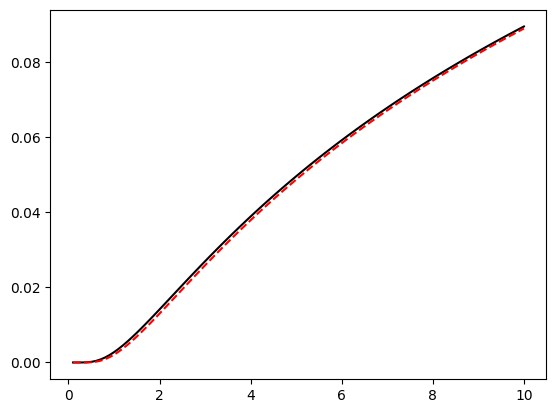

In [126]:
t=np.zeros(100)
for ik in range(100):
    t[ik]=(ik+1)*0.1
s=np.zeros(100)
for ik in range(100):
    u=95.0*95.0*0.001/4.0/1.0/t[ik]
    w=-0.5772-np.log(u)
    for jk in range(1,100):
        w=w-((-1.0)**(jk))*(u**jk)/(jk*1.0)/np.math.factorial(jk)
    s[ik]=1.0/4.0/np.pi/1.0*w
plt.plot(t,s,'k-')
s1=np.zeros(100)
ta=1.0; ss=0.001
r0=np.zeros(1000)
r0[0]=0.1
for ik in range(1,1000):
    r0[ik]=ik*1.0
for ik in range(100):
    rkk=95.0; tk=t[ik]
    for jk in range(1,401):
        vk=jk*1.0*np.pi/lk
        nk=(jk-1)*2
        t_term=np.exp(-vk*vk*ta/ss*tk)
        s1[ik]=s1[ik]+ck[nk+0]*t_term*scipy.special.jv(0,rkk*vk)
        s1[ik]=s1[ik]+ck[nk+1]*t_term*scipy.special.yv(0,rkk*vk)
    s1[ik]=s1[ik]
            
plt.plot(t,52.0-s1,'r--')

In [ ]:
#forward calculation for pumping (2D)
from scipy.optimize import least_squares
import numpy as np
import scipy
from scipy import special
from numpy.polynomial.hermite import hermfit,hermval
from numpy.polynomial.polynomial import polyfit 
import matplotlib.pyplot as plt
import math
from scipy.signal import savgol_filter
from scipy.optimize import differential_evolution
from scipy.optimize import minimize

def fun_der1(lk1,lk2,r,q,ta,s,t,r0):
    t_len=len(t); r_len=len(r); ini_len=len(r0)
    rcoe=np.zeros((ini_len+2+t_len*(r_len+2),100*4))
    ycoe=np.zeros(ini_len+2+t_len*(r_len+2))
# Initial Condition
    for ik in range(ini_len):
        rk=r0[ik]
        for jk in range(1,101):
            if (rk<100.0):
                vk=jk*1.0*np.pi/lk1
                nk=(jk-1)*2
                rk1=rk
            else:
                vk=jk*1.0*np.pi/lk2
                nk=(jk-1)*2+200
                rk1=rk-99.8
            rcoe[ik,nk+0]=scipy.special.jv(0,rk1*vk)
            rcoe[ik,nk+1]=scipy.special.yv(0,rk1*vk)
        ycoe[ik]=52.0
# For the interface in the initial condition
    nk_f=ini_len
    rk=100.0
    for jk in range(1,101):
        vk=jk*1.0*np.pi/lk1
        nk=(jk-1)*2
        rcoe[nk_f,nk+0]=scipy.special.jv(0,rk*vk)
        rcoe[nk_f,nk+1]=scipy.special.yv(0,rk*vk)
        
        vk=jk*1.0*np.pi/lk2
        nk=(jk-1)*2+200
        rk1=rk-99.8
        rcoe[nk_f,nk+0]=-scipy.special.jv(0,rk1*vk)
        rcoe[nk_f,nk+1]=-scipy.special.yv(0,rk1*vk)
    ycoe[nk_f]=0.0
    nk_f=nk_f+1    
    
    for jk in range(1,101):
        vk=jk*1.0*np.pi/lk1
        nk=(jk-1)*2
        rcoe[nk_f,nk+0]=vk*scipy.special.jvp(0,rk*vk)
        rcoe[nk_f,nk+1]=vk*scipy.special.yvp(0,rk*vk)
        
        vk=jk*1.0*np.pi/lk2
        nk=(jk-1)*2+200
        rk1=rk-99.8
        rcoe[nk_f,nk+0]=-vk*scipy.special.jvp(0,rk1*vk)
        rcoe[nk_f,nk+1]=-vk*scipy.special.yvp(0,rk1*vk)
    ycoe[nk_f]=1.0e-2
    nk_f=nk_f+1
    
    for ik in range(t_len):
        tk=t[ik]
# Boundary Condition
        rk=r[0]
        for jk in range(1,101):
            vk=jk*1.0*np.pi/lk1
            nk=(jk-1)*2
            t_term=np.exp(-vk*vk*ta/s*tk)
            rcoe[nk_f,nk+0]=t_term*scipy.special.jvp(0,rk*vk)*vk
            rcoe[nk_f,nk+1]=t_term*scipy.special.yvp(0,rk*vk)*vk
        ycoe[nk_f]=+q/2.0/np.pi/rk/1.0
        nk_f=nk_f+1
        
        rk=r[1]-99.8
        for jk in range(1,101):
            vk=jk*1.0*np.pi/lk2
            nk=(jk-1)*2+200
            t_term=np.exp(-vk*vk*ta/s*tk)
            rcoe[nk_f,nk+0]=t_term*scipy.special.jv(0,rk*vk)
            rcoe[nk_f,nk+1]=t_term*scipy.special.yv(0,rk*vk)
        ycoe[nk_f]=52.0
        nk_f=nk_f+1
    
# For interface
        rk=100.0
        for jk in range(1,101):
            vk=jk*1.0*np.pi/lk1
            nk=(jk-1)*2
            t_term=np.exp(-vk*vk*ta/s*tk)
            rcoe[nk_f,nk+0]=t_term*scipy.special.jv(0,rk*vk)
            rcoe[nk_f,nk+1]=t_term*scipy.special.yv(0,rk*vk)
            
            vk=jk*1.0*np.pi/lk2
            nk=(jk-1)*2+200
            rk1=rk-99.8
            t_term=np.exp(-vk*vk*ta/s*tk)
            rcoe[nk_f,nk+0]=-t_term*scipy.special.jv(0,rk1*vk)
            rcoe[nk_f,nk+1]=-t_term*scipy.special.yv(0,rk1*vk)
        ycoe[nk_f]=0.0
        nk_f=nk_f+1
        
        for jk in range(1,101):
            vk=jk*1.0*np.pi/lk1
            nk=(jk-1)*2
            t_term=np.exp(-vk*vk*ta/s*tk)
            rcoe[nk_f,nk+0]=t_term*vk*scipy.special.jvp(0,rk*vk)
            rcoe[nk_f,nk+1]=t_term*vk*scipy.special.yvp(0,rk*vk)
            
            vk=jk*1.0*np.pi/lk2
            nk=(jk-1)*2+200
            rk1=rk-99.8
            t_term=np.exp(-vk*vk*ta/s*tk)
            rcoe[nk_f,nk+0]=-t_term*vk*scipy.special.jvp(0,rk1*vk)
            rcoe[nk_f,nk+1]=-t_term*vk*scipy.special.yvp(0,rk1*vk)
        ycoe[nk_f]=0.0
        nk_f=nk_f+1
            
    ck=np.linalg.lstsq(rcoe,ycoe,rcond=None)[0]
    
# Calculate the residual
    resk1=np.zeros(ini_len+2+t_len*(r_len+2))
# Initial Condition
    for ik in range(ini_len):
        rk=r0[ik]
        for jk in range(1,101):
            if (rk<100.0):
                vk=jk*1.0*np.pi/lk1
                nk=(jk-1)*2
                rk1=rk
            else:
                vk=jk*1.0*np.pi/lk2
                nk=(jk-1)*2+200
                rk1=rk-99.8
            resk1[ik]=resk1[ik]+ck[nk+0]*scipy.special.jv(0,rk1*vk)
            resk1[ik]=resk1[ik]+ck[nk+1]*scipy.special.yv(0,rk1*vk)
        resk1[ik]=resk1[ik]-52.0
# For the interface in the initial condition
    nk_f=ini_len
    rk=100.0
    for jk in range(1,101):
        vk=jk*1.0*np.pi/lk1
        nk=(jk-1)*2
        resk1[nk_f]=resk1[nk_f]+ck[nk+0]*scipy.special.jv(0,rk*vk)
        resk1[nk_f]=resk1[nk_f]+ck[nk+1]*scipy.special.yv(0,rk*vk)
        
        vk=jk*1.0*np.pi/lk2
        nk=(jk-1)*2+200
        rk1=rk-99.8
        resk1[nk_f]=resk1[nk_f]-ck[nk+0]*scipy.special.jv(0,rk1*vk)
        resk1[nk_f]=resk1[nk_f]-ck[nk+1]*scipy.special.yv(0,rk1*vk)
    nk_f=nk_f+1
    
    for jk in range(1,101):
        vk=jk*1.0*np.pi/lk1
        nk=(jk-1)*2
        resk1[nk_f]=resk1[nk_f]+ck[nk+0]*vk*scipy.special.jvp(0,rk*vk)
        resk1[nk_f]=resk1[nk_f]+ck[nk+1]*vk*scipy.special.yvp(0,rk*vk)
        
        vk=jk*1.0*np.pi/lk2
        nk=(jk-1)*2+200
        rk1=rk-99.8
        resk1[nk_f]=resk1[nk_f]-ck[nk+0]*vk*scipy.special.jvp(0,rk1*vk)
        resk1[nk_f]=resk1[nk_f]-ck[nk+1]*vk*scipy.special.yvp(0,rk1*vk)
    nk_f=nk_f+1
    
    for ik in range(t_len):
        tk=t[ik]
# Boundary Condition
        rk=r[0]
        for jk in range(1,101):
            vk=jk*1.0*np.pi/lk1
            nk=(jk-1)*2
            t_term=np.exp(-vk*vk*ta/s*tk)
            resk1[nk_f]=resk1[nk_f]+ck[nk+0]*t_term*scipy.special.jvp(0,rk*vk)*vk
            resk1[nk_f]=resk1[nk_f]+ck[nk+1]*t_term*scipy.special.yvp(0,rk*vk)*vk
        resk1[nk_f]=resk1[nk_f]-q/2.0/np.pi/rk/1.0
        nk_f=nk_f+1
        
        rk=r[1]-99.8
        for jk in range(1,101):
            vk=jk*1.0*np.pi/lk2
            nk=(jk-1)*2+200
            t_term=np.exp(-vk*vk*ta/s*tk)
            resk1[nk_f]=resk1[nk_f]+ck[nk+0]*t_term*scipy.special.jv(0,rk*vk)
            resk1[nk_f]=resk1[nk_f]+ck[nk+1]*t_term*scipy.special.yv(0,rk*vk)
        resk1[nk_f]=resk1[nk_f]-52.0
        nk_f=nk_f+1
            
# For interface
        rk=100.0
        for jk in range(1,101):
            vk=jk*1.0*np.pi/lk1
            nk=(jk-1)*2
            t_term=np.exp(-vk*vk*ta/s*tk)
            resk1[nk_f]=resk1[nk_f]+ck[nk+0]*t_term*scipy.special.jv(0,rk*vk)
            resk1[nk_f]=resk1[nk_f]+ck[nk+1]*t_term*scipy.special.yv(0,rk*vk)
            
            vk=jk*1.0*np.pi/lk2
            nk=(jk-1)*2+200
            rk1=rk-99.8
            t_term=np.exp(-vk*vk*ta/s*tk)
            resk1[nk_f]=resk1[nk_f]-ck[nk+0]*t_term*scipy.special.jv(0,rk1*vk)
            resk1[nk_f]=resk1[nk_f]-ck[nk+1]*t_term*scipy.special.yv(0,rk1*vk)
        nk_f=nk_f+1
        
        for jk in range(1,101):
            vk=jk*1.0*np.pi/lk1
            nk=(jk-1)*2
            t_term=np.exp(-vk*vk*ta/s*tk)
            resk1[nk_f]=resk1[nk_f]+ck[nk+0]*t_term*vk*scipy.special.jvp(0,rk*vk)
            resk1[nk_f]=resk1[nk_f]+ck[nk+1]*t_term*vk*scipy.special.yvp(0,rk*vk)
            
            vk=jk*1.0*np.pi/lk2
            nk=(jk-1)*2+200
            rk1=rk-99.8
            t_term=np.exp(-vk*vk*ta/s*tk)
            resk1[nk_f]=resk1[nk_f]-ck[nk+0]*t_term*vk*scipy.special.jvp(0,rk1*vk)
            resk1[nk_f]=resk1[nk_f]-ck[nk+1]*t_term*vk*scipy.special.yvp(0,rk1*vk)
        nk_f=nk_f+1
            
    print (sum(resk1*resk1))
    return ck,rcoe,ycoe
r0=np.zeros(1000)
r0[0]=0.15
for ik in range(1,1000):
    r0[ik]=ik*1.0
r=np.zeros(2)
r[0]=0.1; r[1]=1000.0
t=np.zeros(100)
for ik in range(100):
    t[ik]=(ik+1)*0.1
lk1=1000.0; lk2=10000.0
[ck,rcoe,ycoe]=fun_der1(lk1,lk2,r,1.0,1.0,0.001,t,r0)